# Plots

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.optimize import minimize 
from datetime import timedelta
import datetime as dt
from IPython.display import Image
import requests
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

## Data Brazil

Data source: [Brasil.IO](https://brasil.io/dataset/covid19/caso). Observe the database changes every day.



In [2]:
#url = "https://brasil.io/dataset/covid19/caso/?format=csv"
#filename = 'data/brazil_' + url.split("/")[-3] + '.csv'
#with open(filename, "wb") as f:
#    r = requests.get(url)
#    f.write(r.content)

To keep the same analysis, we keep the data basis from May 17.

In [388]:
filename = 'data/brazil_covid19_05_17.csv'

df = pd.read_csv(filename)
df.head()

,date,state,city,place_type,confirmed,deaths,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2020-05-17,AL,Anadia,city,5,1,True,17545.0,2700201.0,28.49815,0.2000
1,2020-05-17,AL,Arapiraca,city,130,6,True,231747.0,2700300.0,56.09566,0.0462
2,2020-05-17,AL,Atalaia,city,29,1,True,47185.0,2700409.0,61.46021,0.0345
3,2020-05-17,AL,Barra de Santo Antônio,city,3,0,True,15932.0,2700508.0,18.83003,0.0000
4,2020-05-17,AL,Barra de São Miguel,city,9,0,True,8322.0,2700607.0,108.14708,0.0000


Select a particular state or city:

In [389]:
state_or_city = 'state'
#state_or_city = 'city'

name = 'SP'
#name = 'São Paulo'

df = df[ df['place_type'] == state_or_city]
df = df[ df[state_or_city] == name ]

df_I = df.groupby('date')[['confirmed']].sum()
df_I.index = pd.to_datetime(df_I.index)
today = df_I.index[-1] + timedelta(days=1)

Last day of data used to run this notebook:

In [390]:
fit_until = df_I.index[-1].strftime('%m-%d')
fit_until

'05-17'

Eventually, data for some days are not avalible depending on the city or state. Thus, the must be a shift in the model to take these absent days into accont.

In [391]:
start = df_I.index[0]
end = df_I.index[-1]
time_I = pd.date_range(start, end, freq= 'D')

shift_NaN = np.abs( len(time_I) - len(df_I.index) )  

#### Population data combined with ICU adimission probability by age

Data source: [IBGE](https://www.ibge.gov.br/apps/populacao/projecao/).

In [396]:
# State of São Paulo
file = 'data/pop_age_str_IBGE_2020_' + 'SP' + '.csv'

# Other states
# file = 'data/pop_age_str_IBGE_2020_' + name + '.csv'

df_age = pd.read_csv(file)
df_age.loc[0, 'Age'] = '00-04'
df_age.loc[1, 'Age'] = '05-09'
df_age['AGE_prob'] = df_age['Total'] / df_age['Total'].sum()

# Selected state
pop0 = df_age['Total'].sum().item()

# City of São Paulo
# pop0 = 	12252023

## ICU admission by age plot

Data source: https://www.cdc.gov/mmwr/volumes/69/wr/mm6912e2.htm?s_cid=mm6912e2_w

In [397]:
df_age_ICU = pd.DataFrame(columns=['Age', 'ICU_prob'])
df_age_ICU['Age'] = ['0-19', '20-44', '45-54', '55-64', '65-74', '75-84', '85+']
df_age_ICU['ICU_prob'] = [0, 4.2, 10.4, 11.2, 18.8, 31, 29]

In [398]:
ICU_prob = [0., 0., 0., 0., 0.042, 
            0.042, 0.042, 0.042, 0.042, 0.104,
            0.104, 0.112, 0.112, 0.188, 0.188,
            0.31, 0.31, 0.29, 0.29]

df_age['ICU_prob'] = ICU_prob

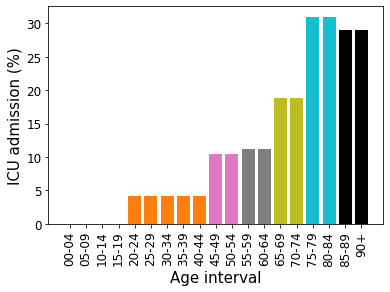

In [399]:
fig, ax = plt.subplots()

ax.bar(df_age['Age'][0:4], 100*df_age['ICU_prob'][0:4], color = 'C0')
ax.bar(df_age['Age'][4:9], 100*df_age['ICU_prob'][4:9], color = 'C1')
ax.bar(df_age['Age'][9:11], 100*df_age['ICU_prob'][9:11], color = 'C6')
ax.bar(df_age['Age'][11:13], 100*df_age['ICU_prob'][11:13], color = 'C7')
ax.bar(df_age['Age'][13:15], 100*df_age['ICU_prob'][13:15], color = 'C8')
ax.bar(df_age['Age'][15:17], 100*df_age['ICU_prob'][15:17], color = 'C9')
ax.bar(df_age['Age'][17:19], 100*df_age['ICU_prob'][17:19], color = 'k')
ax.set_xlabel('Age interval', fontsize= 15)
ax.set_ylabel('ICU admission (%)', fontsize= 15)
ax.tick_params(axis= 'x', labelrotation= 90)
ax.tick_params(axis='x', labelsize= 12)
ax.tick_params(axis='y', labelsize= 12)

#filename = 'results/figures/FIGURE_AGE_ICU_'
#plt.savefig(filename + '.pdf', bbox_inches='tight')

plt.show()

## Age-structured population plot

Data source: https://www.ibge.gov.br/apps/populacao/projecao/

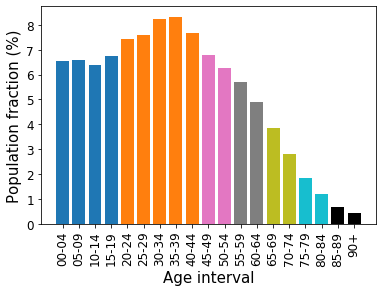

In [400]:
fig, ax = plt.subplots()

ax.set_xlabel('Age interval', fontsize= 15)
ax.set_ylabel('Population fraction (%)', fontsize= 15)

ax.bar(df_age['Age'][0:4], 100*df_age['AGE_prob'][0:4], color = 'C0')
ax.bar(df_age['Age'][4:9], 100*df_age['AGE_prob'][4:9], color = 'C1')
ax.bar(df_age['Age'][9:11], 100*df_age['AGE_prob'][9:11], color = 'C6')
ax.bar(df_age['Age'][11:13], 100*df_age['AGE_prob'][11:13], color = 'C7')
ax.bar(df_age['Age'][13:15], 100*df_age['AGE_prob'][13:15], color = 'C8')
ax.bar(df_age['Age'][15:17], 100*df_age['AGE_prob'][15:17], color = 'C9')
ax.bar(df_age['Age'][17:19], 100*df_age['AGE_prob'][17:19], color = 'k')
ax.tick_params(axis= 'x', labelrotation= 90)
ax.tick_params(axis='x', labelsize= 12)
ax.tick_params(axis='y', labelsize= 12)

#filename = 'results/figures/FIGURE_AGE_str_state_SP_'
#plt.savefig(filename + '.pdf', bbox_inches='tight')

plt.show()

## Data World

Data source: [Our World in Data](https://github.com/owid/covid-19-data/tree/master/public/data). Observe the database changes every day.

In [401]:
#url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
#filename = 'data/world_' + url.split("/")[-1]
#with open(filename, "wb") as f:
#    r = requests.get(url)
#    f.write(r.content)

To keep the same analysis, we keep the data basis from May 17.

In [402]:
filename = 'data/world_owid-covid-data_05_17.csv'

df_W = pd.read_csv(filename)
df_W = df_W[df_W.location != 'Hong Kong']
df_W = df_W[df_W['iso_code'].notna()]
df_W.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN


We focus on two scenarios defined on the other notebook (cite).

## Fit sigmoid over data

$$ \hat{n}(t) =  \frac{\hat{n}^{*}}{1 + e^{-\alpha(t - t_0)}}  $$



In [403]:
country1 = 'Spain'
country2 = 'Switzerland'

frac1 = list(df_W[ df_W['location'] == country1]['total_cases_per_million'])[-1] / 10**6
frac2 = list(df_W[ df_W['location'] == country2]['total_cases_per_million'])[-1] / 10**6

n_star1 = frac1 * pop0
n_star2 = frac2 * pop0

### Linear regression over $\log(\hat{n}^{*} / \hat{n}(t)  - 1 )$

In [406]:
S = 1

X_ = np.arange(len(df_I))
X = X_.reshape(-1, 1)

# The model is fitted with a subnotification factor
y1 = np.log( n_star1 / np.array( S * df_I) - 1. )
y1 = y1.reshape(len(df_I)).reshape(-1, 1)

y2 = np.log( n_star2 / np.array( S * df_I) - 1. )
y2 = y2.reshape(len(df_I)).reshape(-1, 1)

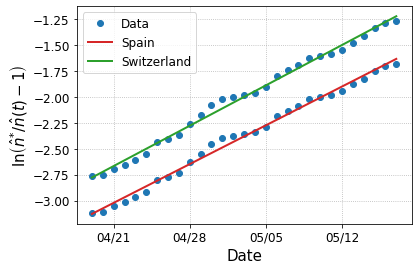

In [287]:
fig, ax = plt.subplots()

ax.plot(df_I.index[t0:], -y1[t0:], 'o', color= 'C0', label= 'Data')
ax.plot(df_I.index[t0:], -model1.predict(X)[t0:], color= 'C3', label= country1, lw= 2.0 )

ax.plot(df_I.index[t0:], -y2[t0:], 'o', color= 'C0')
ax.plot(df_I.index[t0:], -model2.predict(X)[t0:], color= 'C2', label= country2, lw= 2.0)

ax.grid(linestyle=':')
ax.set_xlabel('Date', fontsize= 15)
ax.set_ylabel('$ \\ln \\left( \\hat{n}^{*} / \\hat{n}(t) - 1 \\right) $', fontsize= 15)
#axs.tick_params(labelrotation= 45)
#axs.legend()

ax.tick_params(axis='x', labelsize= 12)
ax.tick_params(axis='y', labelsize= 12)


# Define the date format
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

plt.legend(fontsize= 12)

#filename = 'results/figures/FIGURE_FIT_' + state_or_city + '_' + name + '_Spain_Switzerland_fit_until_05_17'
#plt.savefig(filename + '.pdf', bbox_inches='tight')

plt.show()

In [247]:
def sigmoid(t, t0, alpha, n_star, shift_NaN= 0):
    return n_star / (1. + np.exp(-alpha*(t - t0 - shift_NaN)))

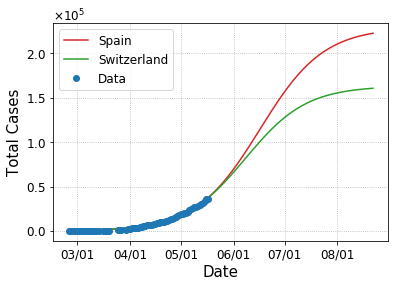

In [248]:
X__ = np.arange(0, 180)

start = df_I.index[0]
end = pd.to_datetime(start, format='%Y/%m/%d') + pd.DateOffset(days= len(X__) - 1)
time = pd.date_range(start, end, freq='D')

n1 = sigmoid(X__, 
             t0= -model1.intercept_[0] / model1.coef_[0][0], 
             alpha= -model1.coef_[0][0], 
             n_star= n_star1,
             shift_NaN= shift_NaN)

n2 = sigmoid(X__, 
             t0= -model2.intercept_[0] / model2.coef_[0][0], 
             alpha= -model2.coef_[0][0], 
             n_star= n_star2,
             shift_NaN= shift_NaN)


fig, ax = plt.subplots()

ax.plot(time, 
        sigmoid(X__, 
                t0= -model1.intercept_[0] / model1.coef_[0][0], 
                alpha= -model1.coef_[0][0], 
                n_star= n_star1,
                shift_NaN= shift_NaN), 
        color= 'C3', label= country1)


ax.plot(time, 
        sigmoid(X__, 
                t0= -model2.intercept_[0] / model2.coef_[0][0], 
                alpha= -model2.coef_[0][0], 
                n_star= n_star2,
                shift_NaN= shift_NaN), 
        color= 'C2', label= country2)

ax.plot(df_I.index, np.array(S * df_I['confirmed']), 'o', color= 'C0', label= 'Data')

ax.grid(linestyle=':')
ax.set_xlabel('Date', fontsize= 15)
ax.set_ylabel('Total Cases', fontsize= 15)

# Define the date format
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)

# Ticjs formats
ax.tick_params(axis='x', labelsize= 12)
ax.tick_params(axis='y', labelsize= 12)

##########
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.yaxis.set_major_formatter(formatter)
ax.yaxis.offsetText.set_fontsize(12)
##########

#ax.ticklabel_format(axis= 'y', style= 'sci', scilimits= (0,0))

#ax.tick_params(labelrotation= 45)
ax.legend(fontsize= 12)

#filename = 'results/figures/FIGURE_FITs_I_' + state_or_city + '_' + name + '_fit_until_05-17'
#plt.savefig(filename + '.pdf', bbox_inches='tight')

plt.show()

Max Spain 2020-05-30 00:00:00
Max Switzerland 2020-05-22 00:00:00


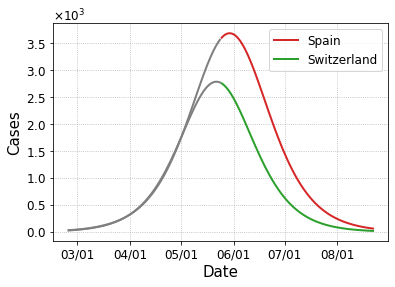

In [413]:
X__ = np.arange(0, 180)
today_ = '2020-05-25'

def derivative(func, x, t0, alpha, n_star, shift_NaN= 0):
    h = 0.0000000001
    return (func(x + h, t0, alpha, n_star, shift_NaN= 0) - func(x, t0, alpha, n_star, shift_NaN= 0)) / h

start = df_I.index[0]
end = pd.to_datetime(start, format='%Y/%m/%d') + pd.DateOffset(days= len(X__) - 1)
time = pd.date_range(start, end, freq='D')

n1 = derivative(sigmoid, X__, 
                t0= -model1.intercept_[0] / model1.coef_[0][0], 
                alpha= -model1.coef_[0][0], 
                n_star= n_star1,
                shift_NaN= shift_NaN)

n2 = derivative(sigmoid, X__, 
                t0= -model2.intercept_[0] / model2.coef_[0][0], 
                alpha= -model2.coef_[0][0], 
                n_star= n_star2,
                shift_NaN= shift_NaN)

index_before = time[ time < today_]
index_after = time [  time >= today_]

print('Max ' + country1, time[np.argmax(n1)])
print('Max ' + country2, time[np.argmax(n2)])

fig, ax = plt.subplots()

##### After
ax.plot(index_after, 
        n1[len(index_before):], 
        color= 'C3', label= country1, lw= 2.0)


ax.plot(index_after, 
       n2[len(index_before):], 
       color= 'C2', label= country2, lw= 2.0)


ax.plot(index_before, 
       n1[:len(index_before)], 
       color= 'C7', lw= 2.0)

ax.plot(index_before, 
       n2[:len(index_before)], 
       color= 'C7', lw= 2.0)

#ax.plot(df_I.index[:-1], np.diff(np.array(S * df_I['confirmed'])), 'o', color= 'C0', label= 'Data')

ax.grid(linestyle=':')
ax.set_xlabel('Date', fontsize= 15)
ax.set_ylabel('Cases', fontsize= 15)

# Define the date format
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)

# Ticjs formats
ax.tick_params(axis='x', labelsize= 12)
ax.tick_params(axis='y', labelsize= 12)

##########
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax.yaxis.set_major_formatter(formatter)
ax.yaxis.offsetText.set_fontsize(12)
##########

#ax.ticklabel_format(axis= 'y', style= 'sci', scilimits= (0,0))

#ax.tick_params(labelrotation= 45)
ax.legend(fontsize= 12)

#ymax1   = df2.loc[df2[n_mean].idxmax()].loc[n_mean] 
#plt.title('São Paulo', fontsize= 18)

#filename = 'HERE___' + state_or_city + '_' + name + '_fit_until_05-17'
#plt.savefig(filename + '.png', bbox_inches='tight')

plt.show()

## ICU demand prediction plots

In [9]:
def plot_scenarios(df1, df2, df_median, dfdata,
                   country1, country2, show1= True, show2= True, showm= True, sub_inform= False, sub_factor= 1.0, data_SUS= False, fit_until= '05-17', 
                   error1= True, error2= True, errorm= False, 
                   SUS= False, ylim= 10000, capacity= 5017, file_s= 'state_SP', Z= 1., save= False, pdf= False):

    file_inf = ''

    if SUS:
        file_s = file_s + '_SUS'
        n_mean = 'n_mean_ICU_SUS'
        n_std  = 'n_std_ICU_SUS'
        median = 'median_SUS'
        std = 'std_SUS'
        y_label = 'Number of ICU beds (SUS)'
        plot_data = False

    else:
        n_mean = 'n_mean_ICU'
        n_std  = 'n_std_ICU'
        median = 'median'
        std = 'std'
        y_label = 'Number of ICU beds'
        plot_data = True
        
        
    today = pd.to_datetime('2020-' + fit_until) + timedelta(days=1)

    fig, ax = plt.subplots()

    df1.index = pd.to_datetime(df1.index)
    df2.index = pd.to_datetime(df2.index)
    dfdata.index = pd.to_datetime(dfdata.index)

    ############################################################################
    ###### SUBNOTIFICATION FACTOR

    if data_SUS:
        n_mean_opt = 'n_mean_ICU_SUS'
        fitted = 'fitted with SUS data'
    else:
        n_mean_opt = 'n_mean_ICU'
        fitted = 'fitted with non-SUS data'

    df1_data = df1.loc[dfdata[dfdata['n_data_ICU'].notnull()].index]
    df2_data = df2.loc[dfdata[dfdata['n_data_ICU'].notnull()].index]
    dfdata_data = dfdata.loc[dfdata[dfdata['n_data_ICU'].notnull()].index]

    def error_(x):
        median = np.median([df1_data[n_mean_opt ], df2_data[n_mean_opt]], axis=0)
        error = ((dfdata_data['n_data_ICU'] - x*median)**2).sum()
        return error

    if sub_inform:
        sub = sub_factor
        print('sub_factor informed = ', sub)
        print('--------')
    else:
        sub = minimize(error_, x0= 10).x[0]
        print('sub_factor calculated = ', sub)
        print('--------')

    ###############################
    ######## MEDIAN

    if showm:
        ax = (sub*df_median[median][today:]).plot(color= 'gold', label= 'Median', linewidth= 2.5)

        file_inf = file_inf + 'MEDIAN_'


        if errorm:
            ax.fill_between(df_median[today:].index,
                            sub*(df_median[median][today:] - Z*df_median[std][today:]),
                            sub*(df_median[median][today:] + Z*df_median[std][today:]),
                            alpha= 0.3, color= 'gold')

    ymaxm   = sub*(df_median.loc[df_median[median].idxmax()].loc[median])
    yerrorm = Z*df_median.loc[df_median[median].idxmax()].loc[std] * sub

    ##### Colapse day
    if capacity > 0:
        colapse_m = df_median[ sub*df_median[median] > capacity ].index.tolist()
        if len(colapse_m) > 0:
            colapse_datem = colapse_m[0].strftime('%Y-%m-%d')
        else:
            colapse_datem = 'no colapse'
    else:
        colapse_datem = 'capacity not informed'
    
    ############################################################################
    ###### DATA
    if plot_data:
        if not sub_inform:
            ax = dfdata['n_data_ICU'].plot(marker= 'o', linestyle= '', color= 'C0', label= 'Data')

    ############################################################################
    ###### AFTER TODAY
    if show1:
        ax = (sub*df1[n_mean][today:]).plot(label= country1, color= 'C3')
        file_inf = file_inf + 'DF1_'

        if error1:
            ax.fill_between(df1[today:].index,
                            sub*(df1[n_mean][today:] - Z*df1[n_std][today:]),
                            sub*(df1[n_mean][today:] + Z*df1[n_std][today:]),
                            alpha= 0.3, color= 'C3')

    ymax1   =  df1.loc[df1[n_mean].idxmax()].loc[n_mean] * sub
    yerror1 = Z*df1.loc[df1[n_mean].idxmax()].loc[n_std] * sub

    if capacity > 0:
        colapse_1 = df1[ sub*df1[n_mean] > capacity ].index.tolist()
        if len(colapse_1) > 0:
            colapse_date1 = colapse_1[0].strftime('%Y-%m-%d')
        else:
            colapse_date1 = 'no colapse'
    else:
        colapse_date1 = 'capacity not informed'

    ############################################################################

    if show2:
        ax = (sub*df2[n_mean][today:]).plot(label= country2, color= 'C2')
        file_inf = file_inf + 'DF2_'

        if error2:
            ax.fill_between(df2[today:].index,
                            sub*(df2[n_mean][today:] - Z*df2[n_std][today:]),
                            sub*(df2[n_mean][today:] + Z*df2[n_std][today:]),
                            alpha= 0.3, color= 'C2')

    ymax2   = df2.loc[df2[n_mean].idxmax()].loc[n_mean] * sub
    yerror2 = Z*df2.loc[df2[n_mean].idxmax()].loc[n_std] * sub

    if capacity > 0:
        colapse_2 = df2[ sub*df2[n_mean] > capacity ].index.tolist()
        if len(colapse_2) > 0:
            colapse_date2 = colapse_2[0].strftime('%Y-%m-%d')
        else:
            colapse_date2 = 'no colapse'
    else:
        colapse_date2 = 'capacity not informed'

    ############################################################################
    ###### BEFORE TODAY
    if show1:
        ax = (sub*df1[n_mean][:today]).plot(color= 'C7', label='_nolegend_')

        ax.fill_between(df1[:today].index,
                        sub*(df1[n_mean][:today] - Z*df1[n_std][:today]),
                        sub*(df1[n_mean][:today] + Z*df1[n_std][:today]),
                        alpha= 0.3, color= 'gray')



    ############################################################################
    if show2:
        ax = (sub*df2[n_mean][:today]).plot(color= 'C7', label='_nolegend_')

        ax.fill_between(df2[:today].index,
                        sub*(df2[n_mean][:today] - Z*df2[n_std][:today]),
                        sub*(df2[n_mean][:today] + Z*df2[n_std][:today]),
                        alpha= 0.3, color= 'gray')

    ############################################################################
    if showm:
        ax = (sub*df_median[median][:today]).plot(color= 'C7', label='_nolegend_')

        ax.fill_between(df_median[:today].index,
                        sub*(df_median[median][:today] - Z*df_median[std][:today]),
                        sub*(df_median[median][:today] + Z*df_median[std][:today]),
                        alpha= 0.3, color= 'gray')

    ############################################################################

    ax.set_ylabel(y_label,fontsize= 15)
    ax.set_xlabel('Date', fontsize= 15)
    ax.set_ylim([0, ylim])

    if capacity > 0:
        ax.axhline(y= capacity, color= 'k', label= 'Capacity', linestyle= ':', linewidth= 2.0)

    ############################################################################
    if capacity > 0:
        l_inf1 = sub*(df1[n_mean] - Z*df1[n_std])
        l_sup1 = sub*(df1[n_mean] + Z*df1[n_std])

        colapse_int1_ = df1[ ( capacity >= l_inf1 ) & ( capacity <= l_sup1)].index
        colapse_int1 = [dt.datetime.strftime(j, '%Y-%m-%d' ) for j in colapse_int1_]

        l_inf2 = sub*(df2[n_mean] - Z*df2[n_std])
        l_sup2 = sub*(df2[n_mean] + Z*df2[n_std])

        colapse_int2_ = df2[ ( capacity >= l_inf2 ) & ( capacity <= l_sup2)].index
        colapse_int2 = [dt.datetime.strftime(j, '%Y-%m-%d' ) for j in colapse_int2_]

        l_infm = sub*(df_median[median] - Z*df_median[std])
        l_supm = sub*(df_median[median] + Z*df_median[std])

        colapse_intm_ = df_median[ ( capacity >= l_infm ) & ( capacity <= l_supm)].index
        colapse_intm = [dt.datetime.strftime(j, '%Y-%m-%d' ) for j in colapse_intm_]

        if show1:
            print('colapse inverval ' + country1 + ': ', colapse_int1)
        if show2:
            print('colapse inverval ' + country2 + ': ', colapse_int2)
        if showm:
            print('colapse inverval ' + 'MEDIAN' + ': ', colapse_intm)

    else:
        colapse_int1 = 'capacity not informed'
        colapse_int2 = 'capacity not informed'
        colapse_intm = 'capacity not informed'

    ############################################################################
    xticks = ax.xaxis.get_major_ticks()
    xticks[0].label1.set_visible(False)
    ############################################################################
    # Define the date format
    date_form = DateFormatter("%m/%d")
    ax.xaxis.set_major_formatter(date_form)
    #ax.legend(fontsize= 12)
    ax.tick_params(axis= 'x', labelsize= 12)
    ax.tick_params(axis= 'y', labelsize= 12)
    ax.legend(fontsize= 12)
    ############################################################################
    

    filename = 'results/figures/FIGURE_ICU_' + file_s + '_' + file_inf + '_fit_until_' + fit_until 

    if save:
        f = open(filename + '.txt', 'w')
        f.write(file_s + '\n')
        f.write(country1 + ' --- max: ' + str(ymax1) + ' +- ' + str(yerror1) + ' date: ' + df1[n_mean].idxmax().strftime('%Y-%m-%d') + ' --- Colapse: ' +                      colapse_date1 + '\n')
        f.write(country2 + ' --- max: ' + str(ymax2) + ' +- ' + str(yerror2) + ' date: ' + df2[n_mean].idxmax().strftime('%Y-%m-%d') + ' --- Colapse: ' +                      colapse_date2 +  '\n')
        f.write('median' + ' --- max: ' + str(ymaxm) + ' +- ' + str(yerrorm) + ' date: ' + df_median[median].idxmax().strftime('%Y-%m-%d') + ' --- Colapse: ' + 
                colapse_datem + '\n')
        f.write('sub factor = ' + str(sub) + ' --- ' + fitted + '\n')
        f.write('-----' + '\n')
        f.write('scenarios fitted with ' + file_s + ' data until: ' + fit_until + '\n')
        f.write('-----------' + '\n')
        f.write(country1 + ' --- colapse interval: ' + str(colapse_int1) + '\n')
        f.write('-----' + '\n')
        f.write(country2 + ' --- colapse interval: ' + str(colapse_int2) + '\n')
        f.write('-----' + '\n')
        f.write('median' + ' --- colapse interval: ' + str(colapse_intm) + '\n')
        f.write('-----' + '\n')
        f.write('Z = ' + str(Z))
        f.close()

        if pdf:
            plt.savefig(filename + '.pdf', bbox_inches='tight')
        else:
            plt.savefig(filename + '.png', bbox_inches='tight')

    plt.show()

In [3]:
fit_until = '05-17'
t0 = 45

state_or_city = 'state'
#state_or_city = 'city'

name = 'SP'
#name = 'São Paulo'

country1 = 'Spain'
country2 = 'Switzerland'

In [4]:
file1 = 'results/dfs/df_ICU_' + state_or_city + '_' + name + '_' + country1 + '_t0=' + str(t0) + '_fit_until_' + fit_until + '.pkl'
file2 = 'results/dfs/df_ICU_' + state_or_city + '_' + name + '_' + country2 + '_t0=' + str(t0) + '_fit_until_' + fit_until + '.pkl'
file3 = 'results/dfs/df_ICU_' + state_or_city + '_' + name + '_' + 'MEDIAN' + '_t0=' + str(t0) + '_fit_until_' + fit_until + '_' + country1 + '_' + country2 + '.pkl'


df1_ICU = pd.read_pickle(file1) 
df2_ICU = pd.read_pickle(file2) 
df_median = pd.read_pickle(file3)

In [5]:
df_ICU_data = pd.DataFrame(columns= ['date', 'n_data_ICU'])
df_ICU_data['date'] = df1_ICU.index
df_ICU_data = df_ICU_data.set_index(['date'])

capacity = 5934

###### TWITTER data: state of São Paulo

df_ICU_data.loc['2020-05-17', 'n_data_ICU'] = 4327
df_ICU_data.loc['2020-05-16', 'n_data_ICU'] = 3922
df_ICU_data.loc['2020-05-15', 'n_data_ICU'] = 3904
df_ICU_data.loc['2020-05-14', 'n_data_ICU'] = 3884
df_ICU_data.loc['2020-05-13', 'n_data_ICU'] = 3702
df_ICU_data.loc['2020-05-12', 'n_data_ICU'] = 3818
df_ICU_data.loc['2020-05-11', 'n_data_ICU'] = 3871
df_ICU_data.loc['2020-05-10', 'n_data_ICU'] = 3909
df_ICU_data.loc['2020-05-09', 'n_data_ICU'] = 3794
df_ICU_data.loc['2020-05-08', 'n_data_ICU'] = 3474

sub_factor calculated =  2.0990992635394683
--------
colapse inverval Spain:  ['2020-05-21', '2020-05-22', '2020-05-23', '2020-05-24', '2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28', '2020-05-29', '2020-05-30', '2020-05-31', '2020-06-13', '2020-06-14', '2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19', '2020-06-20', '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28', '2020-06-29']
colapse inverval Switzerland:  ['2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28', '2020-05-29', '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08']


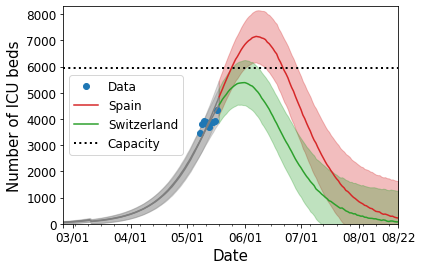

In [10]:
plot_scenarios(df1= df1_ICU, df2= df2_ICU, df_median= df_median, dfdata= df_ICU_data,
               country1= country1, country2= country2, 
               show1= True, show2= True, showm= False, 
               sub_inform= False, sub_factor= 1., data_SUS= False, fit_until= fit_until,
               error1= True, error2= True, errorm= True, 
               SUS= False, ylim= 8300, capacity= 5934,  file_s= 'state_SP',
               Z= 1., save= False, pdf= False)

sub_factor calculated =  2.0990992635394683
--------
colapse inverval MEDIAN:  ['2020-05-22', '2020-05-23', '2020-05-24', '2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28', '2020-05-29', '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08', '2020-06-09', '2020-06-10', '2020-06-11', '2020-06-12', '2020-06-13', '2020-06-14', '2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19', '2020-06-20']


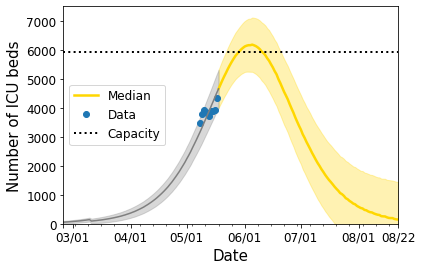

In [12]:
plot_scenarios(df1= df1_ICU, df2= df2_ICU, df_median= df_median, dfdata= df_ICU_data,
               country1= country1, country2= country2, 
               show1= False, show2= False, showm= True, 
               sub_inform= False, sub_factor= 1., data_SUS= False, fit_until= fit_until,
               error1= True, error2= True, errorm= True, 
               SUS= False, ylim= 7500, capacity= 5934,  file_s= 'state_SP_median',
               Z= 1., save= False, pdf= False)

## Predictions

Select a day:

In [15]:
day = '2020-05-22'

Spain scenario:

In [19]:
df1_ICU.loc[day]

n_mean                79934.000000
n_std                   272.740655
n_mean_ICU             2614.898000
n_std_ICU               345.616599
n_mean_ICU_SUS         1641.767000
n_std_ICU_SUS           346.501755
n_mean_ICU_PRIVATE      973.131000
n_std_ICU_PRIVATE       346.117517
Name: 2020-05-22 00:00:00, dtype: float64

Switzerland scenario:

In [21]:
df2_ICU.loc[day]

n_mean                76311.000000
n_std                   267.952065
n_mean_ICU             2350.617000
n_std_ICU               342.722261
n_mean_ICU_SUS         1475.563000
n_std_ICU_SUS           343.526139
n_mean_ICU_PRIVATE      875.054000
n_std_ICU_PRIVATE       343.223067
Name: 2020-05-22 00:00:00, dtype: float64

Median:

In [22]:
df_median.loc[day]

median            2482.757500
std                344.169430
median_SUS        1558.665000
std_SUS            345.013947
median_PRIVATE     924.092500
std_PRIVATE       2483.071378
Name: 2020-05-22 00:00:00, dtype: float64